In [4]:
import requests
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from pymongo import MongoClient
from datetime import datetime

# Define the API endpoint and parameters
url = "https://api.fda.gov/food/enforcement.json?search=report_date:[20200101+TO+20241005]&limit=500"

# Send a GET request to the API
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    recalls = data.get('results', [])
    recall_df = pd.DataFrame(recalls)

    clean_df = recall_df.rename(columns={
        "status": "Status", 
        "city": "City",
        "state": "State",
        "country":"Country",
        "classification":"Classification",
        "openfda":"Open FDA",
        "product_type":"Product Type",
        "event_id":"Event ID",
        "recalling_firm":"Recalling Firm",
        "address_1":"Address 1",
        "address_2":"Address 2",
        "postal_code":"Postal Code",
        "voluntary_mandated":"Voluntary Mandated",
        "initial_firm_notification":"Initial Firm Notification",
        "distribution_pattern":"Distribution Pattern",
        "recall_number":"Recall Number",
        "product_description":"Product Description",
        "product_quantity":"Product Quantity",
        "reason_for_recall":"Reason for Recall",
        "recall_initiation_date":"Recall Initiation Date",
        "center_classification_date":"Center Classification Date",
        "termination_date":"Termination Date",
        "report_date":"Report Date",
        "code_info":"Code Info",
        "more_code_info":"More Code Info",
    })

    # Convert DataFrame to dictionary format for MongoDB
    recall_records = clean_df.to_dict("records")

    # Modify records to ensure the correct structure
    for record in recall_records:
        record['recall_number'] = record.get('recall_number', '')  # Primary key
        record['recall_initiation_date'] = datetime.strptime(record.get('recall_initiation_date', '1900-01-01'), '%Y%m%d') if record.get('recall_initiation_date') else None
        record['recall_classification'] = record.get('classification', '')  # Classification as VARCHAR(50)
        record['status'] = record.get('status', '')  # Status as VARCHAR(50)
        record['product_description'] = record.get('product_description', '')  # Description as TEXT
        record['code_info'] = record.get('code_info', '')  # Code info as TEXT
        record['recalling_firm'] = record.get('recalling_firm', '')  # Firm as VARCHAR(50)
        record['reason_for_recall'] = record.get('reason_for_recall', '')  # Reason as TEXT
        record['distribution_pattern'] = record.get('distribution_pattern', '')  # Pattern as TEXT
        record['state'] = record.get('state', '')  # State as VARCHAR(50)
        record['report_date'] = datetime.strptime(record.get('report_date', '1900-01-01'), '%Y%m%d') if record.get('report_date') else None
        record['voluntary_mandated'] = record.get('voluntary_mandated', '')  # Voluntary/Mandated as VARCHAR(50)
        record['event_id'] = record.get('event_id', '')  # Event ID as VARCHAR(50)

    # Connect to MongoDB
    client = MongoClient('mongodb://localhost:27017/')  # Or use your MongoDB URI
    db = client['fda_recall_data']  # Database name
    collection = db['recalls']  # Collection name

    # Insert modified data into MongoDB
    collection.insert_many(recall_records)

    # Example: Query data back from MongoDB
    recalls_from_db = list(collection.find())



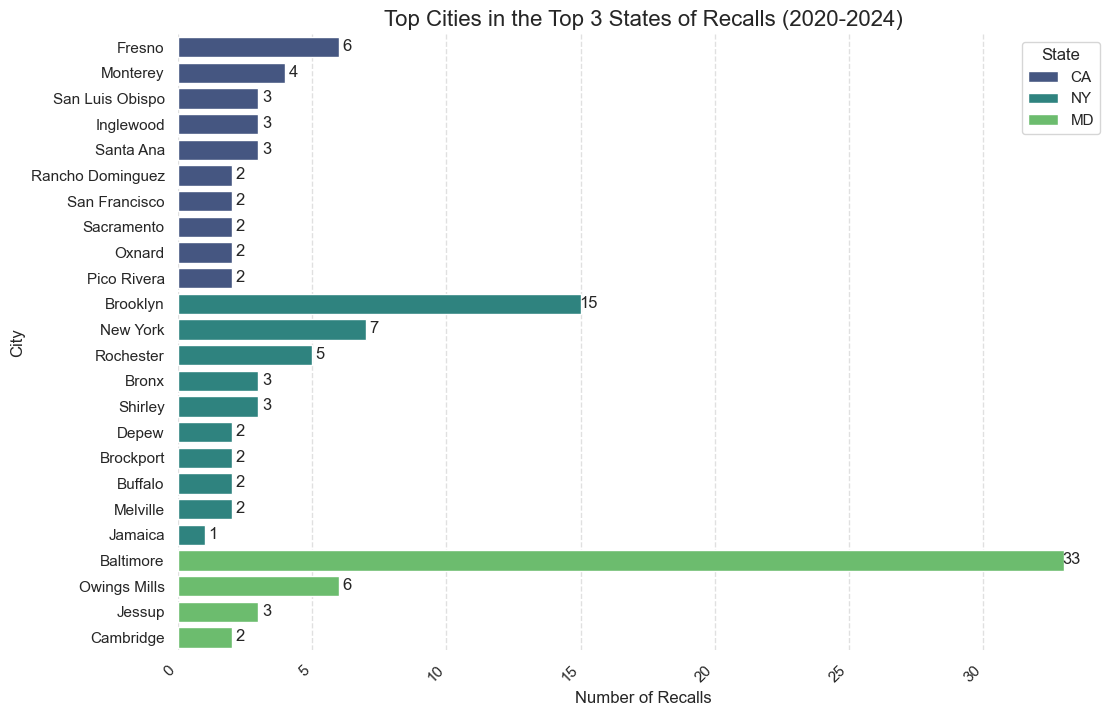

interactive(children=(Dropdown(description='State:', options=('AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', …

In [5]:
# Set plot style
sns.set(style="whitegrid")

# Function to plot the top cities in the top 3 states
def plot_top_3_states():
    state_counts = clean_df['State'].value_counts().reset_index()
    state_counts.columns = ['State', 'Count']

    # Get top 3 states
    top_states = state_counts.head(3)['State']
    top_cities_df = pd.DataFrame()

    # Loop through top states and get city counts
    for state in top_states:
        state_df = clean_df[clean_df['State'] == state]
        city_counts = state_df['City'].value_counts().reset_index()
        city_counts.columns = ['City', 'Count']
        city_counts['State'] = state
        top_cities_df = pd.concat([top_cities_df, city_counts.head(10)], ignore_index=True)

    # Plot the top cities in the top 3 states
    plt.figure(figsize=(12, 8))  # Ensure consistent size
    barplot = sns.barplot(x='Count', y='City', hue='State', data=top_cities_df, palette="viridis")
    plt.title('Top Cities in the Top 3 States of Recalls (2020-2024)', fontsize=16)
    plt.xlabel('Number of Recalls')
    plt.ylabel('City')
    sns.despine(left=True, bottom=True)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right')

    # Add labels
    for p in barplot.patches:
        if int(p.get_width()) > 0:
            barplot.annotate(f'{int(p.get_width())}', (p.get_width() + 0.3, p.get_y() + 0.55), ha='center')

    plt.legend(title='State', loc='upper right')
    plt.show()

# Function to update the plot based on the selected state
def update_plot(state):
    state_df = clean_df[clean_df['State'] == state]
    city_counts = state_df['City'].value_counts().reset_index()
    city_counts.columns = ['City', 'Count']

    if not city_counts.empty:
        plt.figure(figsize=(12, 8))  
        barplot = sns.barplot(x='Count', y='City', hue='City', data=city_counts.head(10), palette="coolwarm")
        plt.title(f'Top Cities in {state} for Recalls (2020-2024)', fontsize=16)
        plt.xlabel('Number of Recalls')
        plt.ylabel('City')
        sns.despine(left=True, bottom=True)
        plt.xticks(rotation=45, ha='right')

        # Add labels
        for index, value in enumerate(city_counts['Count'].head(10)):
            barplot.text(value, index, f'{value}', color='black', va="center", fontsize=12)

        if barplot.legend_:
            barplot.legend_.remove()

        plt.show()
    else:
        print(f"No recall data available for {state}.")

# Plot the top 3 states chart
plot_top_3_states()

# Create a dropdown for state selection, sorted alphabetically
state_dropdown = widgets.Dropdown(
    options=sorted(clean_df[clean_df['Country'] == "United States"]['State'].unique()),
    description='State:',
    disabled=False,
)

#Dropdown 
widgets.interact(update_plot, state=state_dropdown);



In [6]:
# Aggregates the total number of recalls for each state
state_counts = clean_df.groupby('State')['City'].count().reset_index()
state_counts.columns = ['State', 'Recall Count']

# Identifies the city with the highest number of recalls within each state
top_city_by_state = clean_df.groupby(['State', 'City']).size().reset_index(name='City Recalls')
top_city_by_state = top_city_by_state.loc[top_city_by_state.groupby('State')['City Recalls'].idxmax()]

# Merges the total recalls per state with the highest city recalls data
state_counts = pd.merge(state_counts, top_city_by_state[['State', 'City', 'City Recalls']], on='State', how='left')

# Latitude and Longitude for state abbreviations placement
state_abbreviation_coords = {
    'AL': [32.806671, -86.791130], 'AK': [61.370716, -152.404419], 'AZ': [33.729759, -111.431221], 
    'AR': [34.969704, -92.373123], 'CA': [36.116203, -119.681564], 'CO': [39.059811, -105.311104], 
    'CT': [41.597782, -72.755371], 'DE': [39.318523, -75.507141], 'FL': [27.766279, -81.686783], 
    'GA': [33.040619, -83.643074], 'HI': [21.094318, -157.498337], 'ID': [44.240459, -114.478828], 
    'IL': [40.349457, -88.986137], 'IN': [39.849426, -86.258278], 'IA': [42.011539, -93.210526], 
    'KS': [38.526600, -96.726486], 'KY': [37.668140, -84.670067], 'LA': [31.169546, -91.867805], 
    'ME': [44.693947, -69.381927], 'MD': [39.063946, -76.802101], 'MA': [42.230171, -71.530106], 
    'MI': [43.326618, -84.536095], 'MN': [45.694454, -93.900192], 'MS': [32.741646, -89.678696], 
    'MO': [38.456085, -92.288368], 'MT': [46.921925, -110.454353], 'NE': [41.125370, -98.268082], 
    'NV': [38.313515, -117.055374], 'NH': [43.452492, -71.563896], 'NJ': [40.298904, -74.521011], 
    'NM': [34.840515, -106.248482], 'NY': [42.165726, -74.948051], 'NC': [35.630066, -79.806419], 
    'ND': [47.528912, -99.784012], 'OH': [40.388783, -82.764915], 'OK': [35.565342, -96.928917], 
    'OR': [44.572021, -122.070938], 'PA': [40.590752, -77.209755], 'RI': [41.680893, -71.511780], 
    'SC': [33.856892, -80.945007], 'SD': [44.299782, -99.438828], 'TN': [35.747845, -86.692345], 
    'TX': [31.054487, -97.563461], 'UT': [40.150032, -111.862434], 'VT': [44.045876, -72.710686], 
    'VA': [37.769337, -78.169968], 'WA': [47.400902, -121.490494], 'WV': [38.491226, -80.954456], 
    'WI': [44.268543, -89.616508], 'WY': [42.755966, -107.302490]
}

# Function to create the choropleth map that includes state abbreviations
def plot_recall_distribution_by_state():
    clear_output(wait=True)

    # Create the choropleth map
    fig = px.choropleth(
        state_counts,
        locations='State',
        locationmode="USA-states",
        color='Recall Count',
        hover_name='State',
        hover_data={
            'Recall Count': True,
            'City': True,
            'City Recalls': True
        },
        scope="usa",
        color_continuous_scale="YlOrRd",
        labels={'Recall Count': 'Total Recalls'},
        title="Total Recalls by State and Top City (2020-2024)"
    )

    # Add state abbreviations as annotations on the map
    for state, coord in state_abbreviation_coords.items():
        fig.add_trace(go.Scattergeo(
            locationmode='USA-states',
            lon=[coord[1]],
            lat=[coord[0]],
            text=state,
            mode='text',
            showlegend=False,
            textfont=dict(size=12, color="black"),
        ))

    # Updates layout for better visualization and adds a title
    fig.update_layout(
        geo=dict(
            lakecolor='rgb(255, 255, 255)',
        ),
        margin={"r":0,"t":50,"l":0,"b":0},
        title={
            'text': "Total Recalls by State and Top City (2020-2024)",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )

    fig.show()

plot_recall_distribution_by_state()
